In [1]:
import numpy as np
from numpy import polyfit
import pandas as pd
from scipy.optimize import curve_fit
from library import *
from matplotlib import pyplot

In [2]:
data = pd.read_excel('Ship Data.xlsx', index_col=0, header=0)
data['E'] = E(data['L [m]'], data['B [m]'], data['T [m]'], data['D [m]'])
data['CB\''] = data['CB'] + (1-data['CB'])*(0.8*data['D [m]']-data['T [m]'])/(3*data['T [m]'])
data['M_RE'] = M_RE(data['Installed Power [kW]'], type=TANKERS)
data['M_ME'] = data['Machinery Mass [t]'] - data['M_RE']

In [3]:
data['displacement'] = data['L [m]']*data['B [m]'] * data['T [m]'] * data['CB'] * 1.025

In [4]:
param = curve_fit(lambda x,k: k*x, data['displacement']**(1/3), data['L [m]'], 1)[0][0]
permanent = param
def make_L(param):
    def L(displacement):
        return param*displacement**(1/3)
    return L
L = make_L(param)
print("L/Δ^0.33", param)

L/Δ^0.33 5.1688118139016


In [5]:
param = curve_fit(lambda x, k: k*x, data['B [m]'], data['L [m]'])[0][0]
def make_B(param):
    def B(L):
        return L/param
    return B
B = make_B(param)
print("L/B", param)

L/B 6.509259922240642


In [6]:
param = curve_fit(lambda x, k: k*x, data['T [m]'], data['B [m]'])[0][0]
def make_T(param):
    def T(B):
        return B/param
    return T
T = make_T(param)
print("B/T", param)

B/T 2.7084179136266675


In [7]:
param = curve_fit(lambda x, k: k*x, data['D [m]'], data['L [m]'])[0][0]
def make_D(param):
    def D(L):
        return L/param
    return D
D = make_D(param)
print("T/D", param)

T/D 13.499361565653775


In [8]:
param = polyfit(data['Speed [knots]']/np.sqrt(data['L [m]']), data['CB'], 1)
def make_CB(param):
    def CB(V, L):
        return param[0]*V/np.sqrt(L) + param[1]
    return CB
CB = make_CB(param)
print("CB", "b=" + str(param[0]), "a=" + str(param[1]))

CB b=-0.26772545148799376 a=1.0879490354099985


In [9]:
param = curve_fit(lambda x, k: k*x, data['displacement']**(2/3)*data['Speed [knots]']**3, data['Service  Power [kW]'], 1)[0][0]
def make_PS(param):
    def PS(delta, V):
        return param*delta**(2/3)*V**3
    return PS
PS = make_PS(param)
print("P_S", param)

P_S 0.0018499441444316577


In [10]:
param = curve_fit(lambda x, k: k*x, data['E']**1.36*(1+0.5*(data['CB\'']-0.7)), data['Steel Mass [t]']-200, 1)[0][0]
def make_Ws(param):
    def Ws(E, Cb):
        return param*E**1.36*(1+0.5*(Cb-0.7))
    return Ws
Ws = make_Ws(param)
print("W_s", param)

W_s 0.029924932203151722


In [11]:
param = curve_fit(lambda x, k: k*x, data['L [m]']*data['B [m]'], data['Outfit Mass [t]'], 1)[0][0]
def make_Wo(param):
    def Wo(L, B):
        return param*L*B
    return Wo
Wo = make_Wo(param)
print("Wo", param)

Wo 0.2491860708299783


删除离群数据点（影响并不大）

In [12]:
# 删除离群数据点
# d = data[(data.index != 15)]
d = data
# data['M_ME']

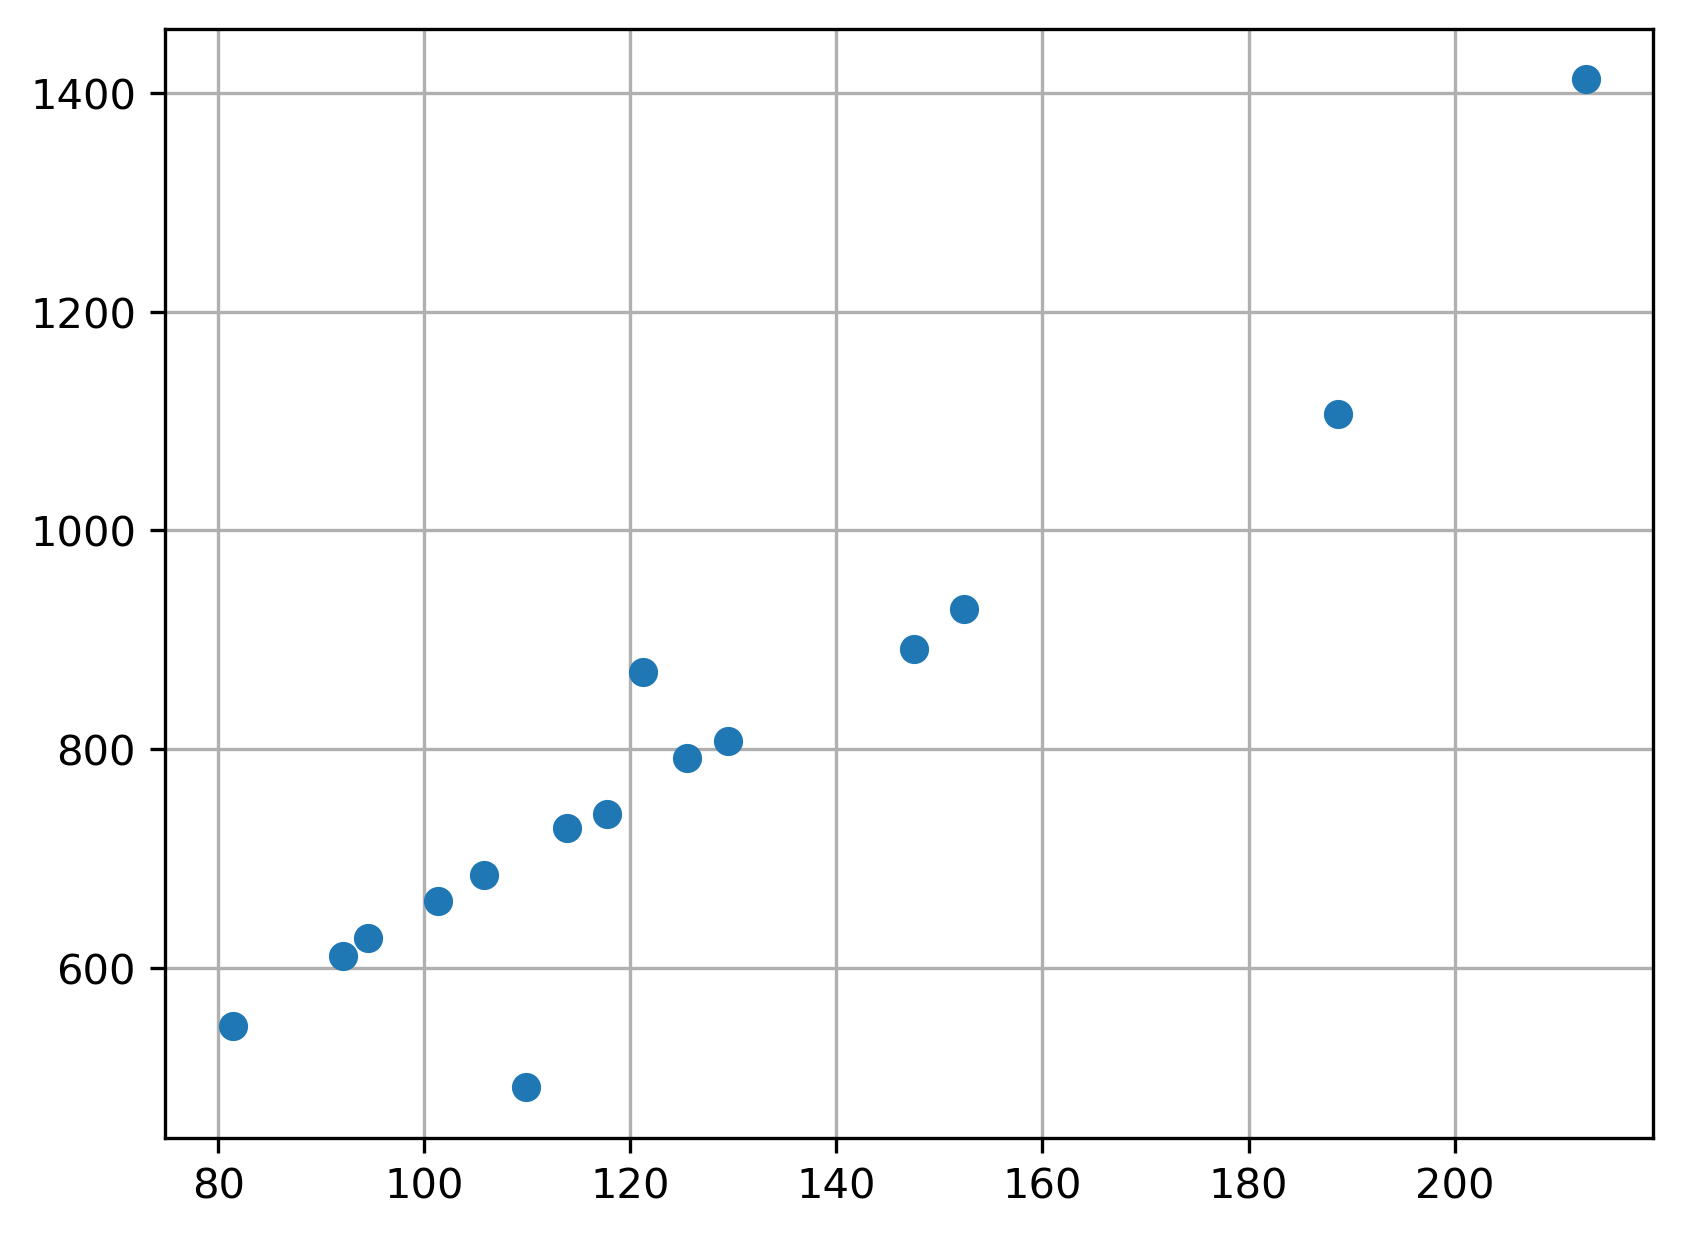

In [13]:
pyplot.figure(dpi=300)
pyplot.grid(True)
pyplot.plot(d['Installed Power [kW]']/d['Engine RPM'], d['M_ME'], 'o')
pyplot.show()

In [14]:
# param, _ = curve_fit(lambda x, a, b: a*x**b, d['Installed Power [kW]']/d['Engine RPM'], d['M_ME']) # 检查一下这个P是安装功率还是服役功率？
param = (8.2815, 0.9475)
def make_Mme(param):
    def Mme(P, N):
        return param[0]*(P/N)**param[1]
    return Mme
Mme = make_Mme(param)
print("Mme", param[0], param[1])

Mme 8.2815 0.9475


In [15]:
data['W4'] = 1.1*data['Service  Power [kW]']*0.205*0.001*data['Range [nm]']/data['Speed [knots]']
data['W5'] = data['Total DWT']-data['Cargo DWT']-data['W4']

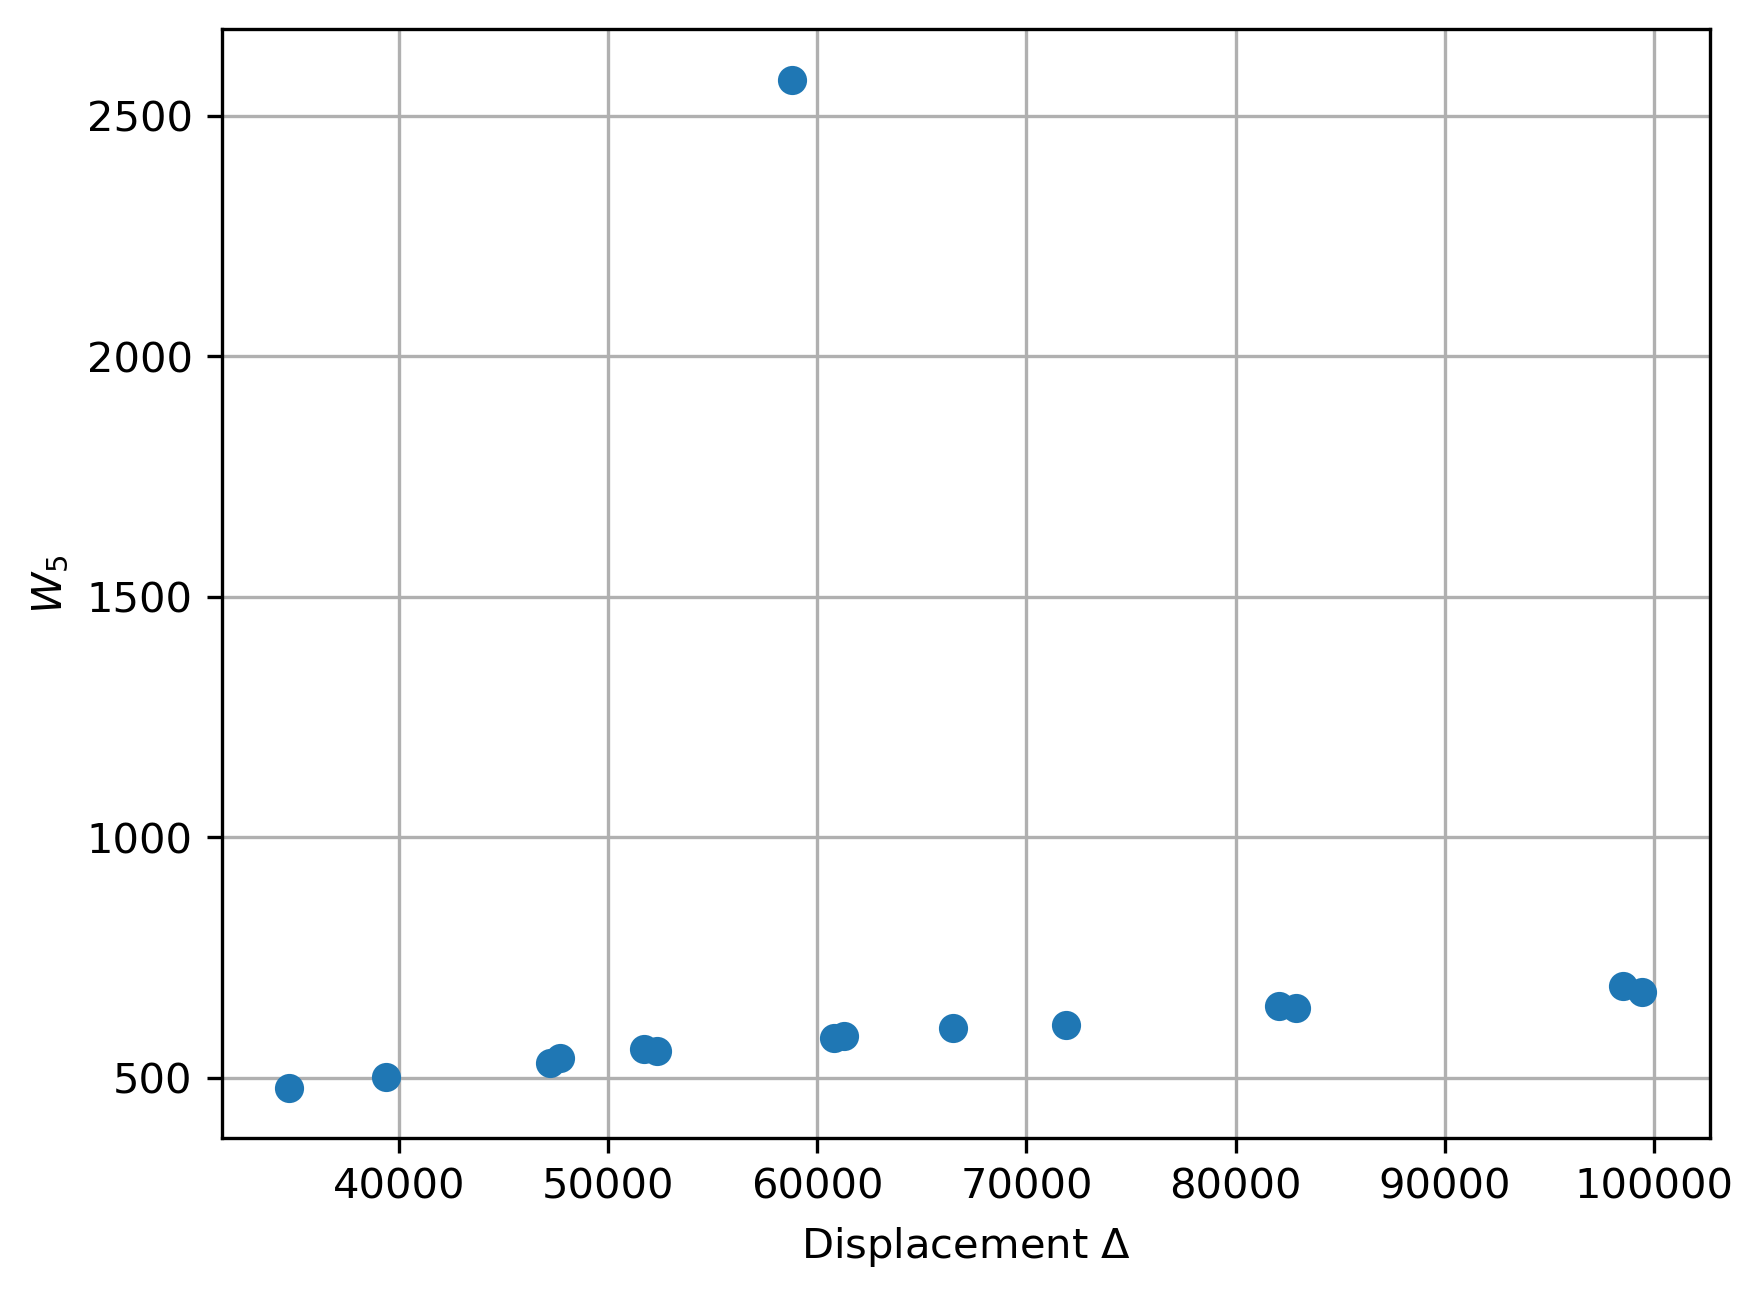

In [16]:
d = data
from matplotlib import pyplot
pyplot.figure(dpi=300)
pyplot.plot(d['displacement'], d['W5'], 'o')
pyplot.ylabel('$W_5$')
pyplot.xlabel('Displacement $\\Delta$')
pyplot.grid(True)
pyplot.show()

Excel计算

In [17]:
# param, _ = curve_fit(lambda x, a, b: a*x**b, d['displacement'], d['W5'])
param = (23.964, 0.2988)
def make_W5(param):
    def W5(displacement):
        return param[0]*displacement**param[1]
    return W5
W5 = make_W5(param)
print("W5", param[0], param[1])

W5 23.964 0.2988


In [18]:
def DWT(L, V, R, log=False):
    """
    计算DWT
    :param L: 船长
    :param V: 速度
    :param R: 航程
    :param log: 是否需要日志
    :return: 
    """
    global B, T
    B0 = B(L)
    T0 = T(B0)
    D0 = D(L)
    CB0 = CB(V, L)
    delta = L * B0 * T0 * 1.025 * CB0
    E0 = E(L, B0, T0, D0)
    Cb0 = Cb(CB0, D0, T0)
    Ws0 = Ws(E0, Cb0)
    Wo0 = Wo(L, B0)
    Ps0 = PS(delta, V)
    Pi0 = Ps0*1.3
    Mme0 = Mme(Ps0, 90)
    Mre0 = M_RE(Pi0, type=TANKERS)
    Wm0 = Mme0 + Mre0
    LS0 = LS(Ws0, Wo0, Wm0)
    W40 = 1.1*Ps0*0.205*R*0.001/V
    W50 = W5(delta)
    if log:
        return delta - LS0 - W40 - W50, {
            'B': B0,
            'T': T0,
            'D': D0,
            'CB': CB0,
            'E': E0,
            'CB\'': Cb0,
            'Ws': Ws0,
            'Wo': Wo0,
            'Ps': Ps0,
            'Pi': Pi0,
            'M_ME': Mme0,
            'M_RE': Mre0,
            'W_m': Wm0,
            'LS': LS0,
            'W4': W40,
            'W5': W50,
            'W6': delta - LS0 - W40 - W50
        }
    else:
        return delta - LS0 - W40 - W50

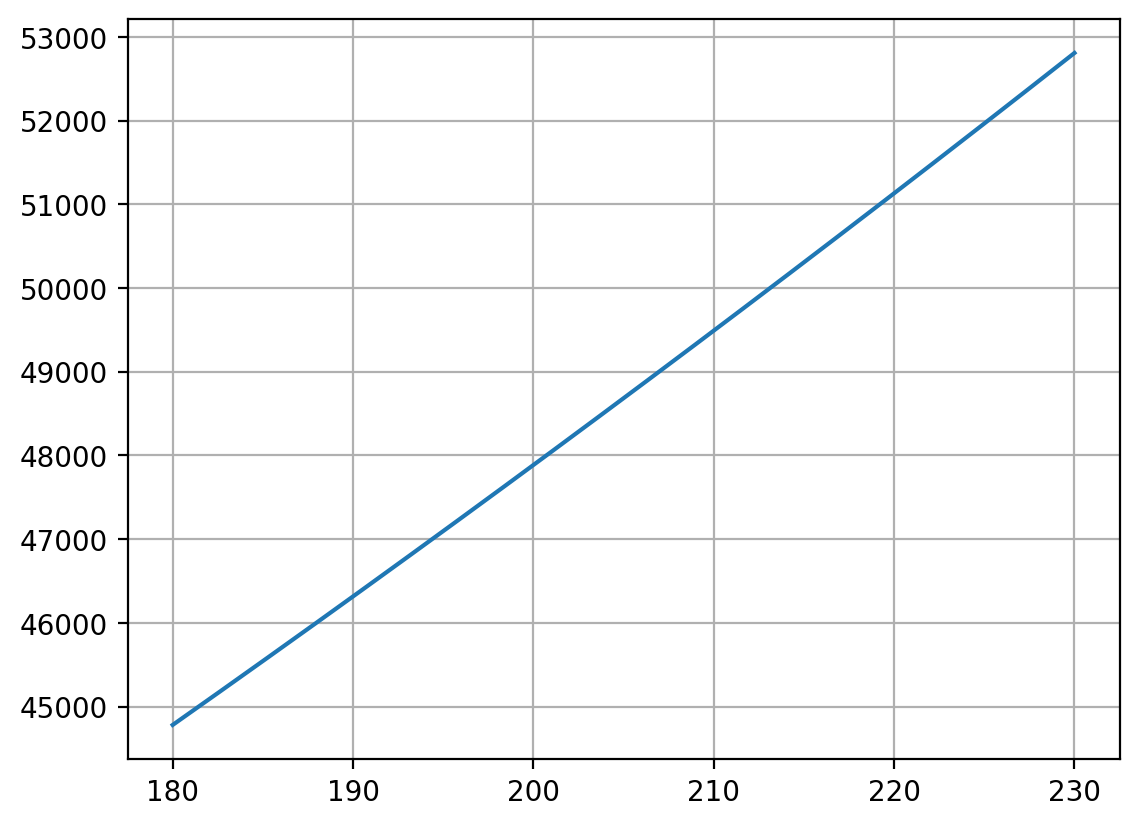

In [19]:
pyplot.figure(dpi=200)
pyplot.plot(np.linspace(180, 230, 20), DWT(np.linspace(200, 210, 20), 15, 12000))
pyplot.grid(True)
pyplot.show()

In [20]:
DWT(207.007, 15, 12000)

50313.03818420446

估算初始估计值

In [21]:
param = curve_fit(lambda x, k: k*x, data['displacement'], data['Cargo DWT'])[0][0]

In [22]:
expect_DWT=50000
next_guess = (expect_DWT * permanent**3 / param) ** (1/3)
V = 15
R = 12000
df = pd.DataFrame()
value, log = DWT(next_guess, V, R, True)
df = pd.concat([df, pd.Series(log, name=next_guess)], axis=1)
err = (expect_DWT - value) / expect_DWT
while (abs(err) > 1e-5):
    next_guess +=err * 15
    value, log = DWT(next_guess, V, R, True)
    # print(log)
    err = (expect_DWT - value) / expect_DWT
    df = pd.concat([df, pd.Series(log, name=next_guess)], axis=1)
print(next_guess)

206.6241841982983


In [26]:
df.to_excel('过程.xlsx')
data.to_excel('11111111.xlsx')

In [28]:
DWT(207.007, 15, 12000)

50313.03818420446